# Data Science Challenge - Semantix Brasil
## Author: Andre Guimaraes Duarte
## Date: March 2018
### Source data: https://archive.ics.uci.edu/ml/datasets/bank+marketing

The data used for this challenge relates to direct marketing campaigns of an undisclosed Portuguese banking institution from 2008 to 2010. The marketing campaigns were based on phone calls, either home (telephone) or cellular. The dependent variable in this dataset is called "y" and denotes whether the client (one client per line) subscribed to a bank term deposit. 

The dataset contains information about each client, such as age, occupation, marital status, degree of education, whether they have defaulted before, their average monthly account balance, whether they have a housing or personal loan, they day and month of last contact, the duration of the last contact, how many contacts were made, as well as previous campaign results.

Using this dataset, it is possible to use data science techniques to do several things. For this challenge, I will limit myself to answering the questions asked about the dataset. Time permitting, I will delve deeper into machine learning models, such as classification to predict whether a client will subscribe to a bank term deposit using logistic regression and random forests.

# Exploratory Data Analysis
The first step when dealing with a new dataset is to explore it, perform early visualizations, look for missing data and potentially imputing said missing data, etc.

In [1]:
# import sys
# reload(sys)
# sys.setdefaultencoding("utf-8")

In [4]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

In [5]:
!pwd

/home/andre/Documents/BankMarketing


In [41]:
file_path = "/home/andre/Documents/BankMarketing/bank-full.csv"
df = pd.read_csv(file_path, sep=";", header=0)

In [7]:
df.shape

(45211, 17)

The dataset has 45,211 lines/observations (clients) and 17 columns (variables). Let's have a look at their types. We are dealing with both numeric and categorical variables, which we might have to modify in order to build our model.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [9]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [10]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

We can see that there are no missing data points in the dataset. We will not have to perform any imputing.

In [11]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


It might be necessary to standardize the numeric fields before constructing our classification model, so that the variables can be assigned weights independent of their spread.

In [16]:
df["y"].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

Out of all the clients, 39.922 result in y="no", while only 5,289 result in y="yes". This means that the accuracy of a model that only predicts "no" will be 88.3% for this dataset. Whatever model we construct needs to perform at least as well as this baseline.

Since we have the day and month, let's construct a new columns with the full date as well as the day of week.

In [42]:
df.loc[:27728,'year'] = '2008'
df.loc[27729:42591,'year'] = '2009'
df.loc[42592:,'year'] = '2010'
df["date"] = pd.to_datetime(df["day"].map(str) + df["month"] + "2008", format="%d%b%Y")
df['weekday'] = df['date'].dt.weekday_name
df.drop(["day","year"], axis=1, inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,date,weekday
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,261,1,-1,0,unknown,no,2008-05-05,Monday
1,44,technician,single,secondary,no,29,yes,no,unknown,may,151,1,-1,0,unknown,no,2008-05-05,Monday
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,76,1,-1,0,unknown,no,2008-05-05,Monday
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,may,92,1,-1,0,unknown,no,2008-05-05,Monday
4,33,unknown,single,unknown,no,1,no,no,unknown,may,198,1,-1,0,unknown,no,2008-05-05,Monday


Let's also update our response variable `y` to be binary ("yes"->1, "no"->0) 

In [43]:
df["y"] = df.y.map({'yes':1, 'no':0})
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,date,weekday
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,261,1,-1,0,unknown,0,2008-05-05,Monday
1,44,technician,single,secondary,no,29,yes,no,unknown,may,151,1,-1,0,unknown,0,2008-05-05,Monday
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,76,1,-1,0,unknown,0,2008-05-05,Monday
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,may,92,1,-1,0,unknown,0,2008-05-05,Monday
4,33,unknown,single,unknown,no,1,no,no,unknown,may,198,1,-1,0,unknown,0,2008-05-05,Monday


In [21]:
df.groupby("y").mean()

,age,balance,duration,campaign,pdays,previous
y,,,,,,
0,40.838986,1303.714969,221.182806,2.846350,36.421372,0.502154
1,41.670070,1804.267915,537.294574,2.141047,68.702968,1.170354


Interesting tidbits about the response:
* on average, clients who subscribe are older than those who don't,
* on average, the average balance is higher for those who subscribe,
* on average, call duration for those who subscribed is higher (which makes sense, as more time is spent explaining the campaign, benefits, etc),
* the above also is reflected by a lower number of calls made to those who subscribed (once they subscribed, no need to continue calling them),
* it also reflects in the previous campaign: a client who previously subscribed is contacted again after a longer period on average than for someone who didn't previously subscribe,
* on average, people who subscribe were contacted more in the previous campaign than those who don't subscribe.

These points are all coherent and make intuitive sense. Now let's try to dig a little bit deeper in the other categorical variables.

## Categorical variables
Here, we will explore the categorical variables and see which ones are good candidates for being good predictors in our classification model.

In [111]:
"""
Function that produces and plots a stacked barplot of the input variable var
with respect to the success (y=="yes"/y==1).
"""
def stackedBarplot(var, fig, y="y", num_figs=1, pos=1):
    if not var or var == "" or not var in df.columns.tolist():
        return
    ax = fig.add_subplot(1, num_figs, pos)
    table = pd.crosstab(df[var], df[y])
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.title('Stacked proportion of {} per {}'.format(y, var))
    plt.xlabel(var)
    plt.ylabel('Proportion')
    plt.xticks(rotation=30)

fig = plt.figure()

In [22]:
df.groupby("job").mean()

,age,balance,duration,campaign,pdays,previous,y
job,,,,,,,
admin.,39.289886,1135.838909,246.896732,2.575324,47.859021,0.671630,0.122027
blue-collar,40.044081,1078.826654,262.901562,2.816995,44.033498,0.505138,0.072750
entrepreneur,42.190989,1521.470074,256.309348,2.799597,32.486214,0.478144,0.082717
housemaid,46.415323,1392.395161,245.825000,2.820968,21.505645,0.371774,0.087903
management,40.449567,1763.616832,253.995771,2.864348,38.665468,0.668006,0.137556
retired,61.626767,1984.215106,287.361307,2.346731,37.443905,0.638693,0.227915
self-employed,40.484484,1647.970868,268.157061,2.853072,34.747308,0.551615,0.118429
services,38.740250,997.088108,259.318729,2.718344,41.995185,0.501204,0.088830
student,26.542644,1388.060768,246.656716,2.299574,57.041578,0.953092,0.286780


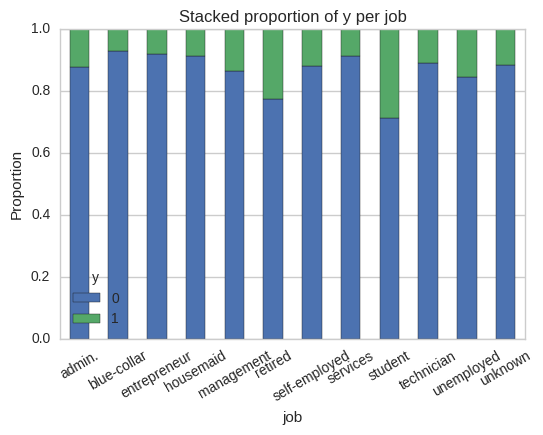

In [112]:
stackedBarplot("job", fig)

It seems that students are the most likely to subscribe to a bank term deposit, followed by retired and unemployed clients. This is interesting and we will go further on this later in this notebook.

In [34]:
df.groupby("loan").mean()

,age,balance,duration,campaign,pdays,previous,y
loan,,,,,,,
no,41.008823,1474.453631,259.559275,2.750336,41.192983,0.591435,0.126557
yes,40.555632,774.309912,250.845389,2.834622,34.982054,0.522087,0.066814


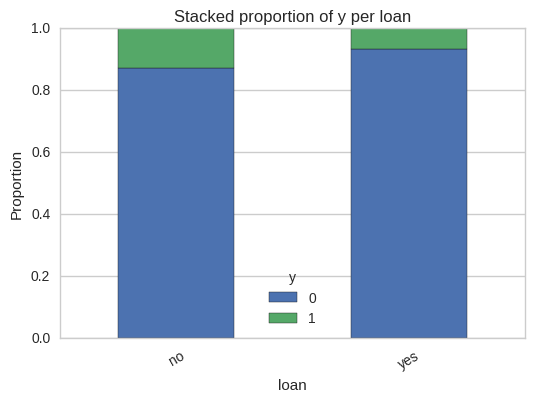

In [113]:
stackedBarplot("loan", fig)

Clients with personal loans are less likely to subscribe.

In [24]:
df.groupby("housing").mean()

,age,balance,duration,campaign,pdays,previous,y
housing,,,,,,,
no,43.139883,1596.501270,256.700911,2.845625,26.288581,0.484787,0.167024
yes,39.175288,1175.103064,259.331476,2.698488,51.312495,0.656665,0.077000


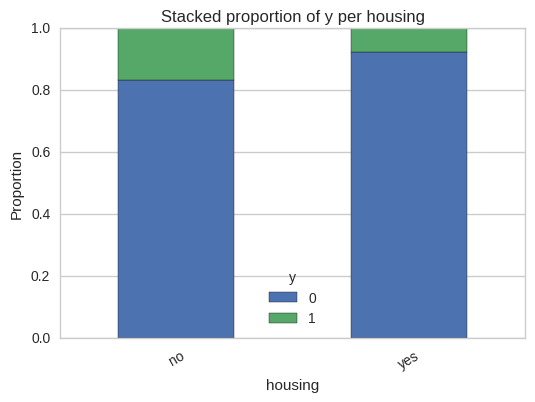

In [114]:
stackedBarplot("housing", fig)

Clients with housing loans are also less likely to subscribe.

In [25]:
df.groupby("marital").mean()

,age,balance,duration,campaign,pdays,previous,y
marital,,,,,,,
divorced,45.782984,1178.872287,262.517188,2.630882,41.001728,0.551373,0.119455
married,43.408099,1425.925590,253.412765,2.842875,37.950467,0.556552,0.101235
single,33.703440,1301.497654,266.497967,2.649805,44.652385,0.642690,0.149492


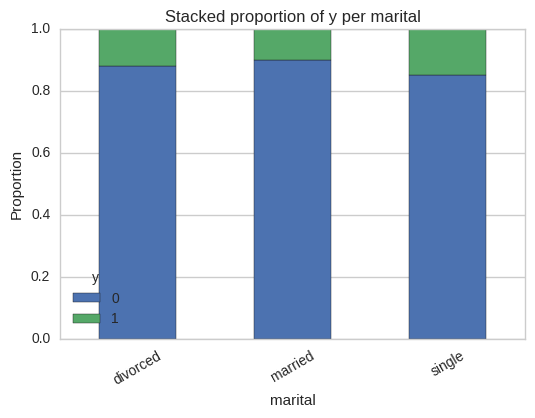

In [115]:
stackedBarplot("marital", fig)

Single clients are more likely to subscribe than divorced or married clients.

In [26]:
df.groupby("default").mean()

,age,balance,duration,campaign,pdays,previous,y
default,,,,,,,
no,40.961934,1389.806424,258.512749,2.756780,40.604536,0.586044,0.117961
yes,39.534969,-137.624540,239.115337,3.148466,18.042945,0.268712,0.063804


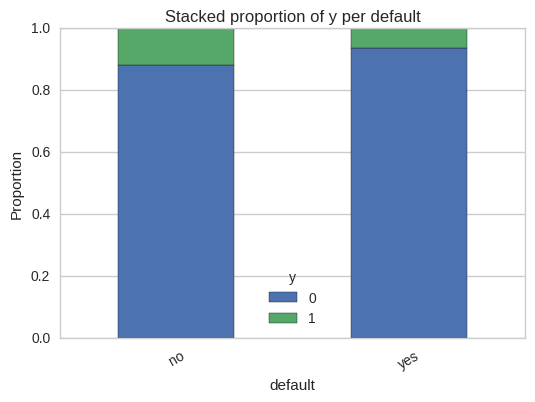

In [116]:
stackedBarplot("default", fig)

Clients who have credit default are less likely to subscribe.

In [27]:
df.groupby("contact").mean()

,age,balance,duration,campaign,pdays,previous,y
contact,,,,,,,
cellular,40.400785,1397.926993,263.013966,2.690114,56.885129,0.804064,0.149189
telephone,47.837922,1803.704061,235.366139,3.400895,46.312801,0.827254,0.134205
unknown,40.600077,1183.550384,252.340476,2.787481,1.299386,0.021966,0.040707


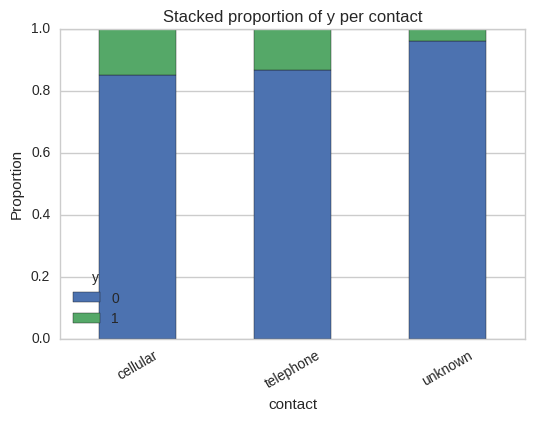

In [117]:
stackedBarplot("contact", fig)

Clients who are contacted on the cellular phones are more likely to subscribe.

In [29]:
df.groupby("weekday").mean()

,age,balance,duration,campaign,pdays,previous,y
weekday,,,,,,,
Friday,40.564112,1441.026517,240.558118,3.202870,7.715038,0.172539,0.064293
Monday,41.785197,1282.024595,256.819446,2.717044,34.015630,0.524997,0.120906
Saturday,41.531350,1352.225884,242.708199,2.243569,97.155949,1.730707,0.227492
Sunday,39.617726,1512.683930,250.116391,2.276829,98.116391,1.351575,0.213027
Thursday,41.298001,1413.047384,257.097976,3.120928,35.779368,0.430281,0.088228
Tuesday,40.719380,1296.255990,264.507523,2.564248,40.598128,0.594561,0.113451
Wednesday,40.698333,1350.472194,270.437395,2.692067,37.628511,0.523778,0.119615


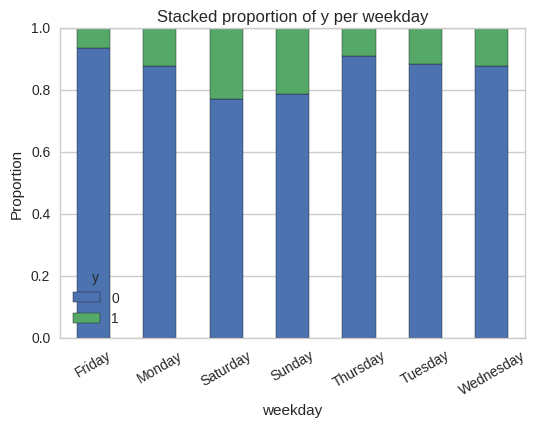

In [118]:
stackedBarplot("weekday", fig)

It seems that day of week is an important factor, as clients contacted on the weekends are more likely to subscribe to bank term loans.

In [44]:
df.groupby("month").mean()

,age,balance,duration,campaign,pdays,previous,y
month,,,,,,,
apr,39.770805,1542.551160,298.098909,1.955321,95.201910,1.052524,0.196794
aug,42.894509,1427.701777,232.402113,3.927325,13.328958,0.278374,0.110133
dec,44.457944,2315.672897,329.327103,2.196262,108.780374,1.803738,0.467290
feb,40.885240,1319.098905,248.298226,2.382031,68.702907,1.182710,0.166478
jan,40.493229,946.783321,268.220242,1.672131,67.898076,1.185317,0.101212
jul,41.008847,900.025526,267.975344,3.524438,8.032342,0.129949,0.090935
jun,42.438120,1608.222243,243.087811,3.135368,9.154465,0.197903,0.102228
mar,42.941300,2046.228512,244.400419,2.205451,71.228512,1.188679,0.519916
may,38.891109,1034.992590,260.922272,2.447552,52.157344,0.584992,0.067195


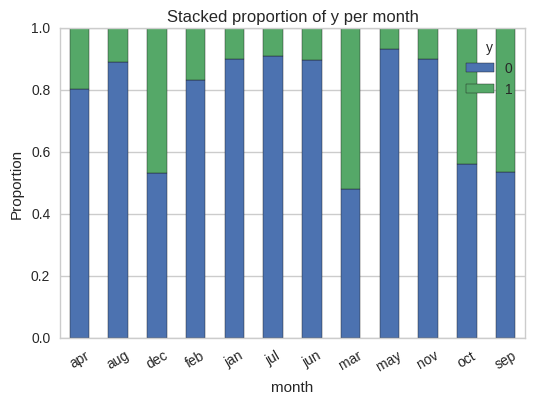

In [119]:
stackedBarplot("month", fig)

It seems that the month of last contact is also a good candidate for a good predictor, as contacts in December, March, October, and September are much more likely to result in a sale than contact in other months.

Based on these results, I would select `job`, `month`, `weekday`, `default`, `housing`, `loan` to be good candidates for predictors.

## Numeric variables
Now, let's do the same for the numeric independent variables.

In [121]:
def histogram(var, fig, bins=10, num_figs=1, pos=1):
    if not var or var == "" or not var in df.columns.tolist():
        return
    ax = fig.add_subplot(1, num_figs, pos)
    df[var].hist(bins=bins)
    plt.title('Histogram of {}'.format(var))
    plt.xlabel(var)
    plt.ylabel('Client count')

In [133]:
# [0;25) -> young
# [25;45) -> lower-adult
# [45;65) -> upper-adult
# [65;100) -> old
df["cat_age"] = pd.cut(df.age, [0, 25, 45, 65, 100], labels=["young","lower-adult","upper-adult","old"], right=False)

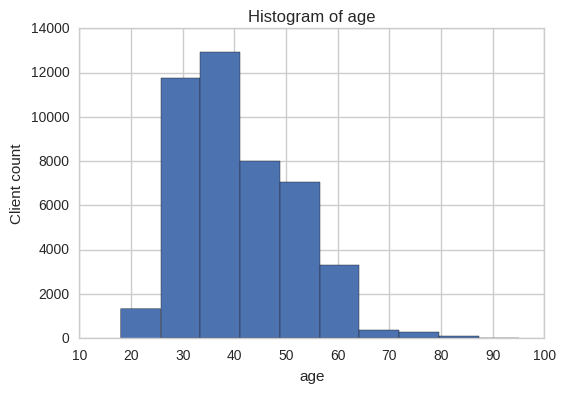

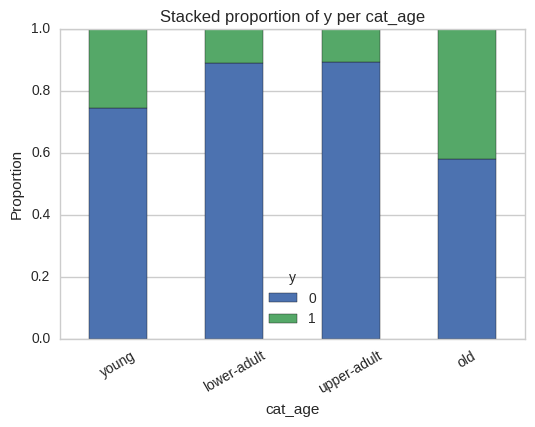

In [134]:
histogram("age", fig, 10, 2, 1)
stackedBarplot("cat_age", fig, "y", 2, 2)

As we've seen before, young people (correlates to students) and old people (correlates to retired) are the most likely to subscribe.

In [135]:
df["cat_balance"] = pd.cut(df.balance, [-10000,0,200,500,1000,1500,1000000], labels=["<0","<200","<500","<1000","<1500",">=1500"], right=False)

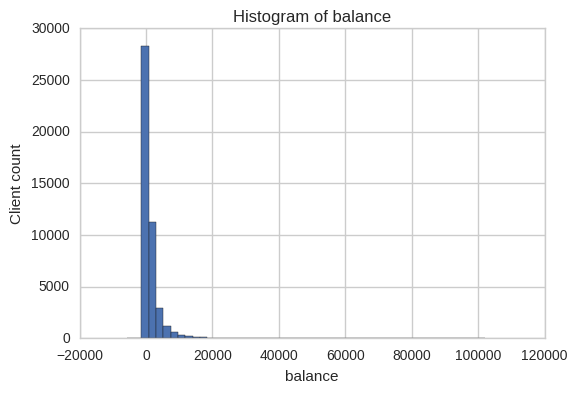

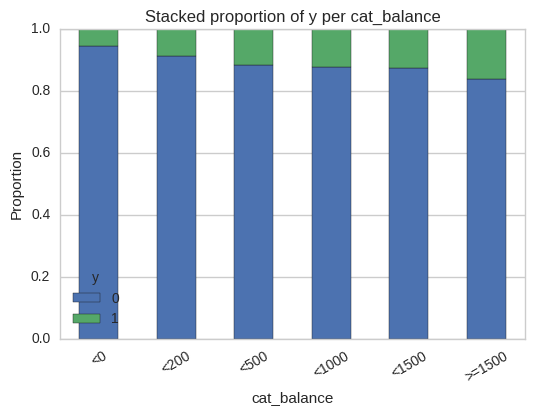

In [136]:
histogram("balance", fig, 50, 2, 1)
stackedBarplot("cat_balance", fig, "y", 2, 2)

Not very suprising, clients with a higher average balance are more likely to subscribe.

In [142]:
df["cat_duration"] = pd.cut(df.duration, [0, 100, 200, 300, 500, 5000], labels=["<100", "<200", "<300", "<500", ">=500"], right=False)

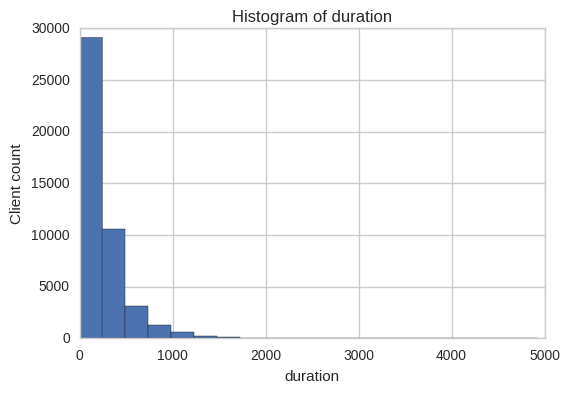

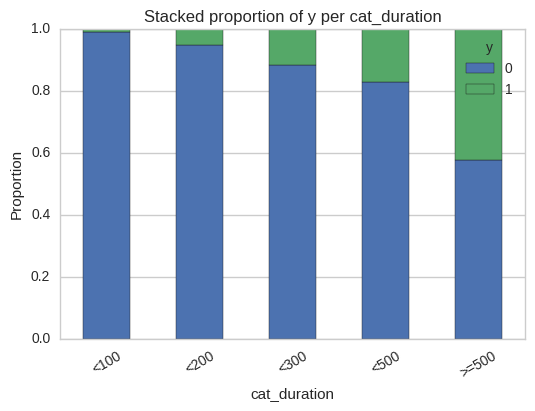

In [143]:
histogram("duration", fig, 20, 2, 1)
stackedBarplot("cat_duration", fig, "y", 2, 2)

As seen before, the duration is highly correlated with the success rate. This is due to fact that longer calls mean the agent spent more time with the client who wanted to subscribe.

In [139]:
df["cat_campaign"] = pd.cut(df.campaign, [1, 2, 3, 10, 65], labels=["One", "Two", "3-10", "10+"], right=False)

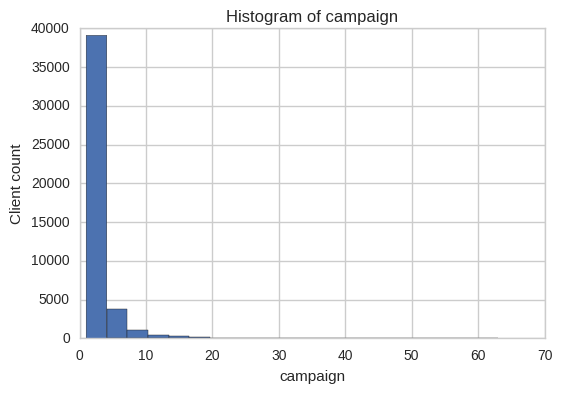

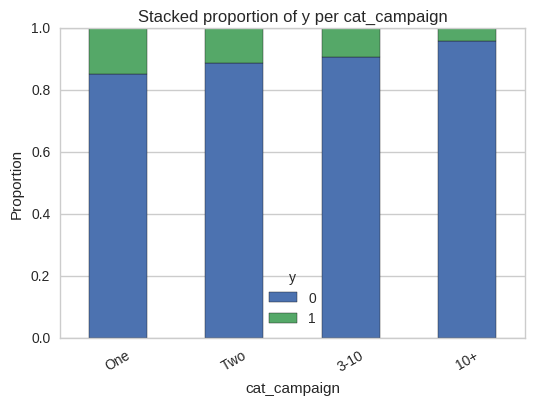

In [140]:
histogram("campaign", fig, 20, 2, 1)
stackedBarplot("cat_campaign", fig, "y", 2, 2)

This may be one of the most surprising early results: more calls do not correspond to more subscriptions. In fact, it the opposite: the best success rate is for only one campaign call.

In [147]:
df["cat_pdays"] = pd.cut(df.pdays, [-1,1,2,3,4,5,10,871], labels=["None", "1", "2", "3", "4", "5-10", "10+"], right=False)

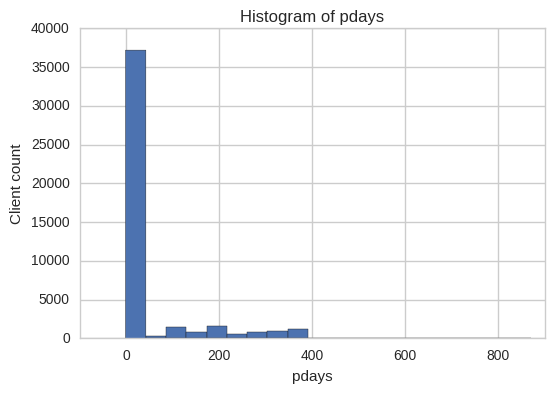

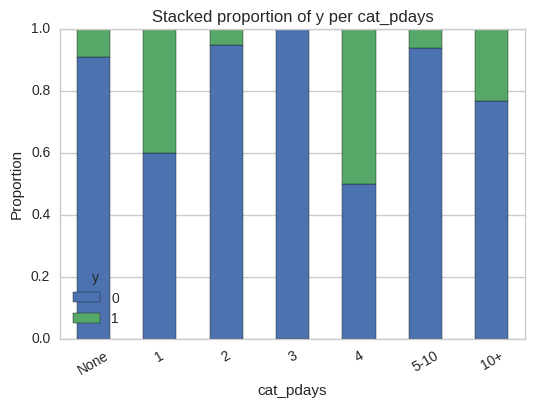

In [148]:
histogram("pdays", fig, 20, 2, 1)
stackedBarplot("cat_pdays", fig, "y", 2, 2)

Four days seems to be the ideal time to wait between successes. One day is also very good.

In [150]:
df["cat_previous"] = pd.cut(df.previous, [0, 1, 2, 3, 4, 5, 10, 1000], labels=["0", "1", "2", "3", "4", "5-10", "10+"], right=False)

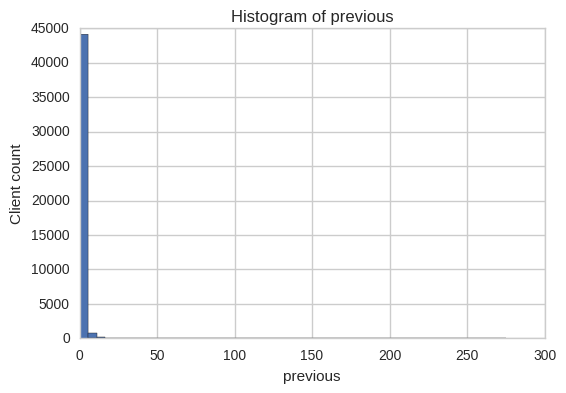

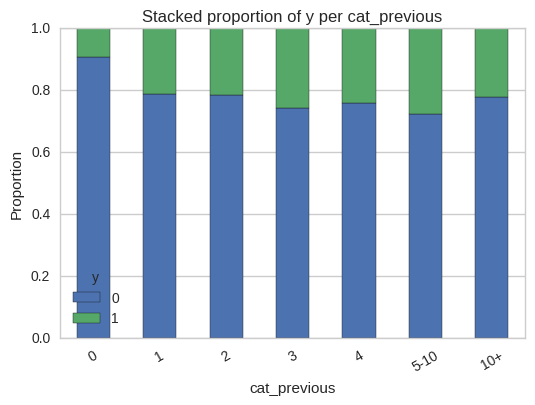

In [151]:
histogram("previous", fig, 50, 2, 1)
stackedBarplot("cat_previous", fig, "y", 2, 2)

It seems like anywhere between 1 to 5 previous contacts for a client have similar positive effects in success rate.

# Challenge questions and answers
Now that we've explored the dataset in detail, let's turn out heads to answering the questions asked.

## Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?

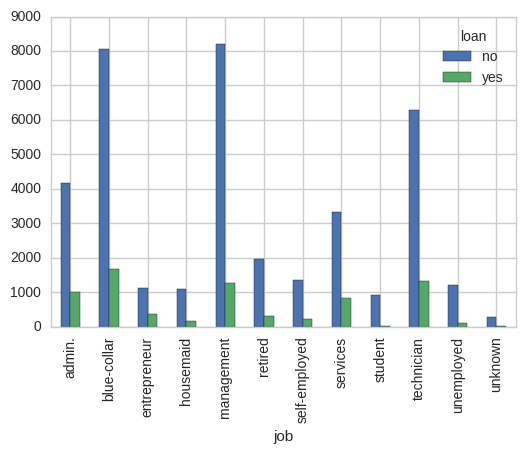

In [73]:
pd.crosstab(df.job, df.loan).plot(kind="bar")

In [19]:
pd.crosstab(df.job, df.loan).apply(lambda r: r/r.sum(), axis=1).sort_values("yes", ascending=False)

loan,no,yes
job,,
entrepreneur,0.760592,0.239408
services,0.798748,0.201252
admin.,0.808354,0.191646
blue-collar,0.826963,0.173037
technician,0.827695,0.172305
self-employed,0.854972,0.145028
retired,0.863516,0.136484
management,0.867520,0.132480
housemaid,0.877419,0.122581


In [20]:
pd.crosstab(df.job, df.housing).apply(lambda r: r/r.sum(), axis=1).sort_values("yes", ascending=False)

housing,no,yes
job,,
blue-collar,0.275791,0.724209
services,0.334136,0.665864
admin.,0.384645,0.615355
entrepreneur,0.415602,0.584398
technician,0.458339,0.541661
management,0.505392,0.494608
self-employed,0.515516,0.484484
unemployed,0.583269,0.416731
housemaid,0.679032,0.320968


/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:894: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


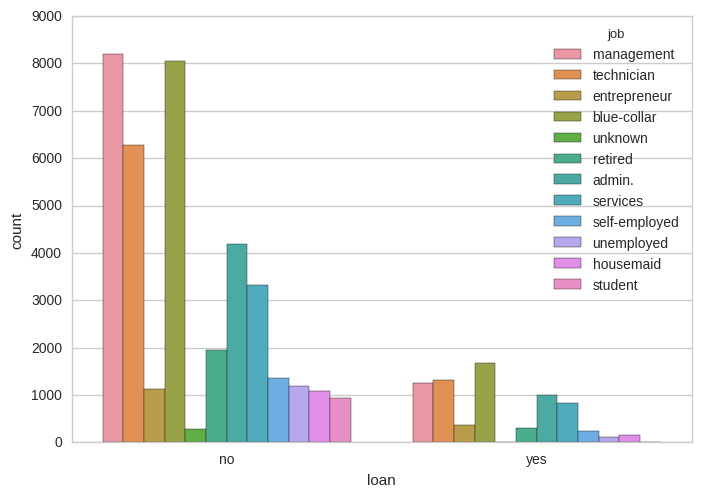

In [21]:
sns.countplot(x="loan", hue="job", data=df)

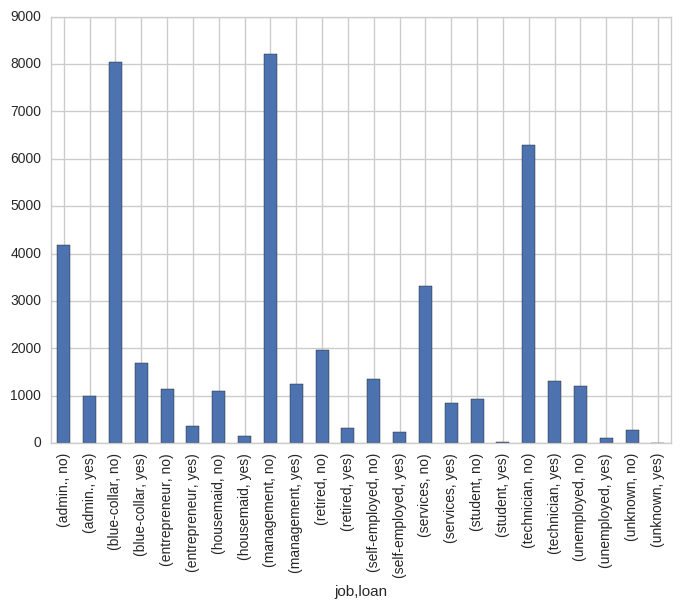

In [22]:
df.groupby("job")["loan"].value_counts().plot(kind="bar")

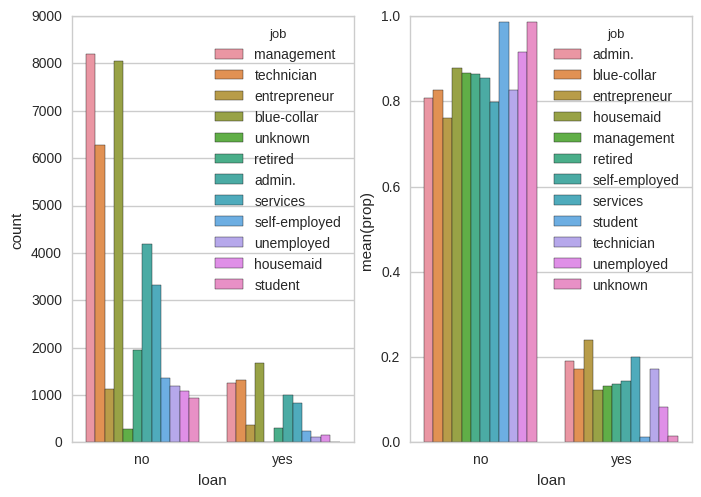

In [23]:
x, y, hue = "loan", "prop", "job"
f, axes = plt.subplots(1, 2)
sns.countplot(x=x, hue=hue, data=df, ax=axes[0])
prop_df = (df[x]\
           .groupby(df[hue])\
           .value_counts(normalize=True)\
           .rename(y)\
           .reset_index())
sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=axes[1])

## Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text xticklabel objects>)

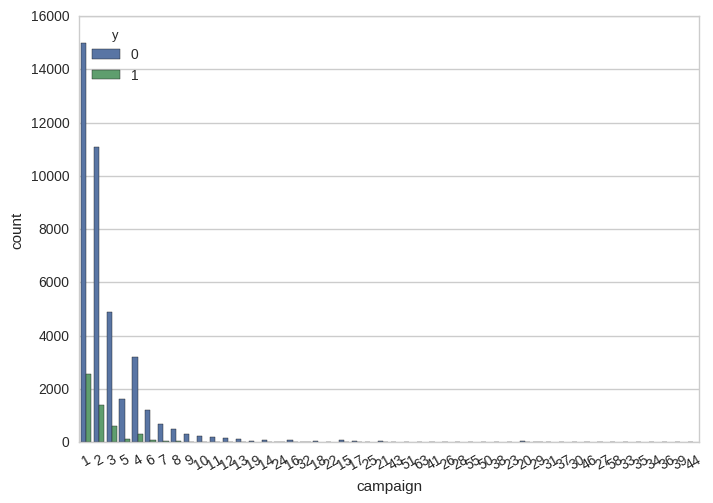

In [24]:
sns.countplot(x="campaign", hue="y", data=df)
plt.xticks(rotation=30)

In [25]:
pd.crosstab(df.campaign, df.y).apply(lambda r: r/r.sum(), axis=1)#.sort_values("yes", ascending=False)

y,0,1
campaign,,
1,0.854024,0.145976
2,0.887965,0.112035
3,0.888064,0.111936
4,0.909994,0.090006
5,0.921202,0.078798
6,0.928737,0.071263
7,0.936054,0.063946
8,0.940741,0.059259
9,0.935780,0.064220


In [26]:
df.groupby("campaign")["y"].count()

campaign
1     17544
2     12505
3      5521
4      3522
5      1764
6      1291
7       735
8       540
9       327
10      266
11      201
12      155
13      133
14       93
15       84
16       79
17       69
18       51
19       44
20       43
21       35
22       23
23       22
24       20
25       22
26       13
27       10
28       16
29       16
30        8
31       12
32        9
33        6
34        5
35        4
36        4
37        2
38        3
39        1
41        2
43        3
44        1
46        1
50        2
51        1
55        1
58        1
63        1
Name: y, dtype: int64

In [49]:
# Dummy variables
df.drop(['day','year','date'], axis=1, inplace=True)
categorical = ['job','marital','education','default','housing','loan','contact','weekday','month','poutcome']
for c in categorical:
    cat_list = 'var'+'_'+c
    cat_list = pd.get_dummies(df[c], prefix=c, drop_first=True)
    tmp = df.join(cat_list)
    df = tmp
to_keep = [i for i in df.columns.values.tolist() if i not in categorical]

In [50]:
df_final = df[to_keep]
df_final.columns.values

array(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
       'contact_unknown', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'], dtype=object)

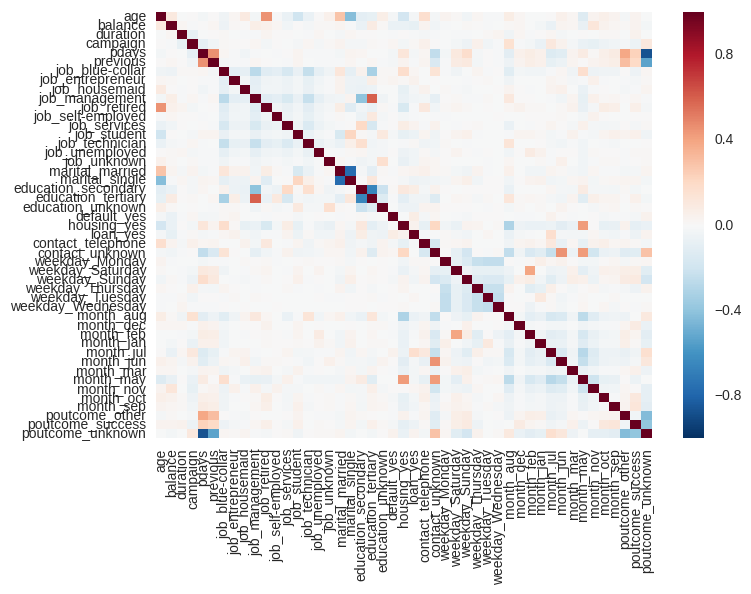

In [51]:
sns.heatmap(df_final.corr())

In [52]:
X = df_final.drop("y", axis=1)
y = df_final.y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [53]:
X_train.shape

(36168, 47)

In [54]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print confusion_matrix

[[7751  229]
 [ 696  367]]


In [56]:
'Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test))

'Accuracy of logistic regression classifier on test set: 0.90'

In [57]:
from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

         no       0.92      0.97      0.94      7980
        yes       0.62      0.35      0.44      1063

avg / total       0.88      0.90      0.88      9043



In [62]:
# import statsmodels.api as sm
# logit = sm.Logit(np.asarray([1 if i=="yes" else 0 for i in y]), X)
# result = logit.fit()
# print result.summary()

## Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão?

## O resultado da campanha anterior tem relevância na campanha atual?

## Qual o fator determinante para que o banco exija um seguro de crédito?

## Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário?